# Feature to response correlation analysis on TF affinity scores obtained from a window of size 500bp around TSS
We decided to change the window size centered on the TSS of the genes estimating the binding affinities of the TFs binding in that region.

## Load the partitioned and normalized data (to save I/O operations)

In [1]:
load("../TF_hg38_500bp_LiHe.RData")

### List of variables in the workspace after loading the data file

In [2]:
print(ls())

[1] "x" "y"


Here we ignore the y, test_y, and train_Y variables as they represent the single cell expression data stored in the RData file. We should instead replace these values with the corresponding bulk expression data.

### Dimensions of the training and test data

In [3]:
print("x:")
print(dim(x))

print("y:")
print(length(y))

[1] "x:"
[1] 52527   726
[1] "y:"
[1] 52527


In [4]:
print(range(x))
print(range(y))

[1] 0.000000 2.149298
[1]     0.0 12081.8


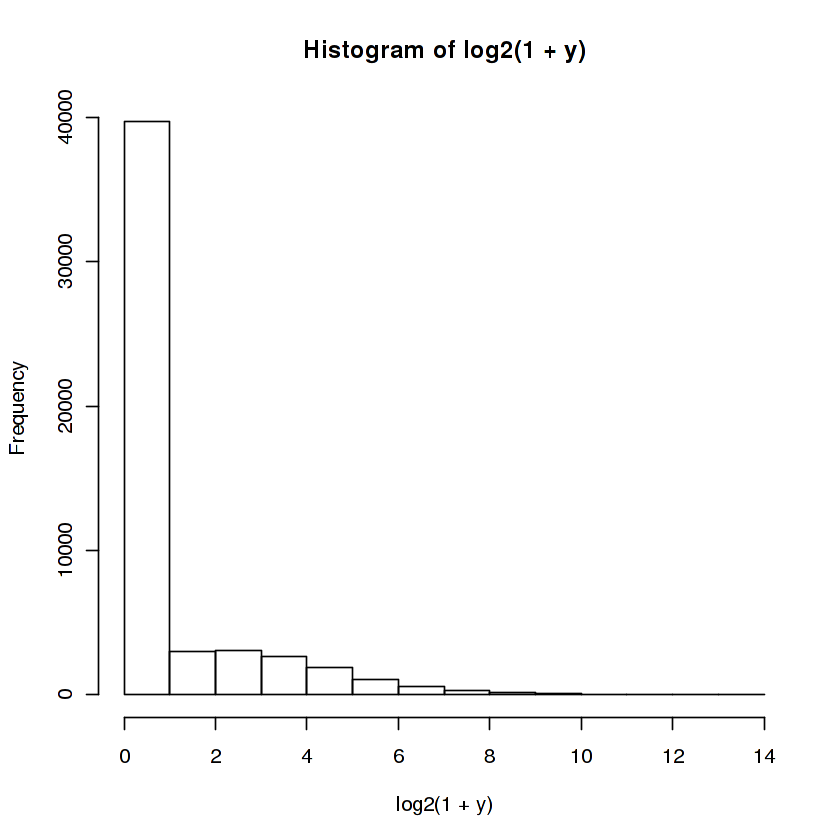

In [5]:
hist(log2(1 + y))

## Compute feature to response correlations (unfiltered data)

### Raw data (original space)

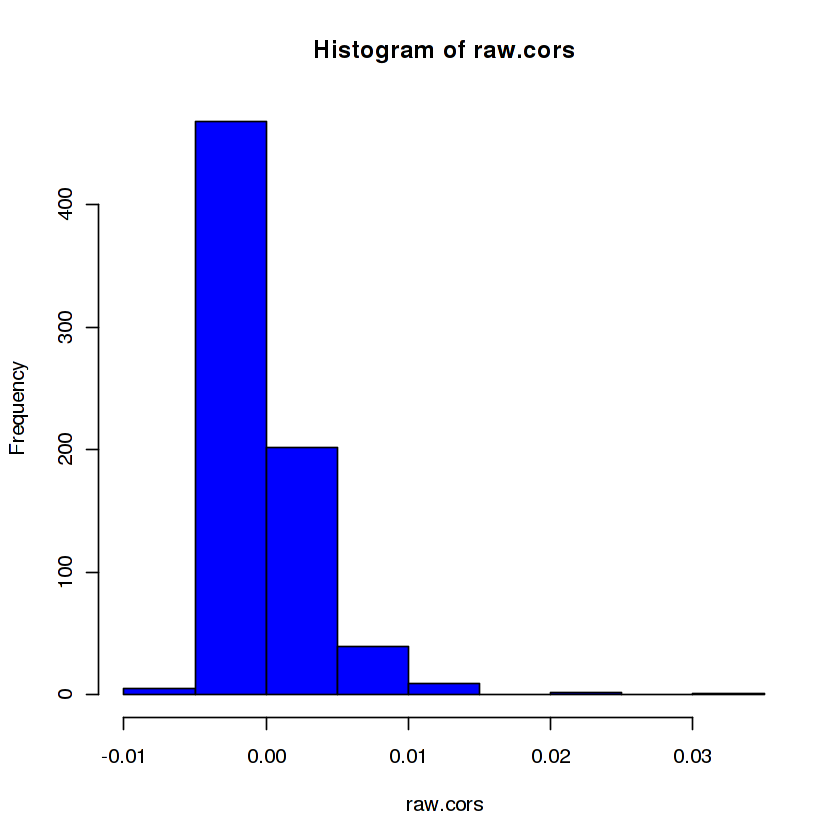

In [6]:
raw.cors <- sapply(seq(ncol(x)), function(i)cor(y, x[, i]))
hist(raw.cors, col= "blue")

### Log-transformed data (log space)

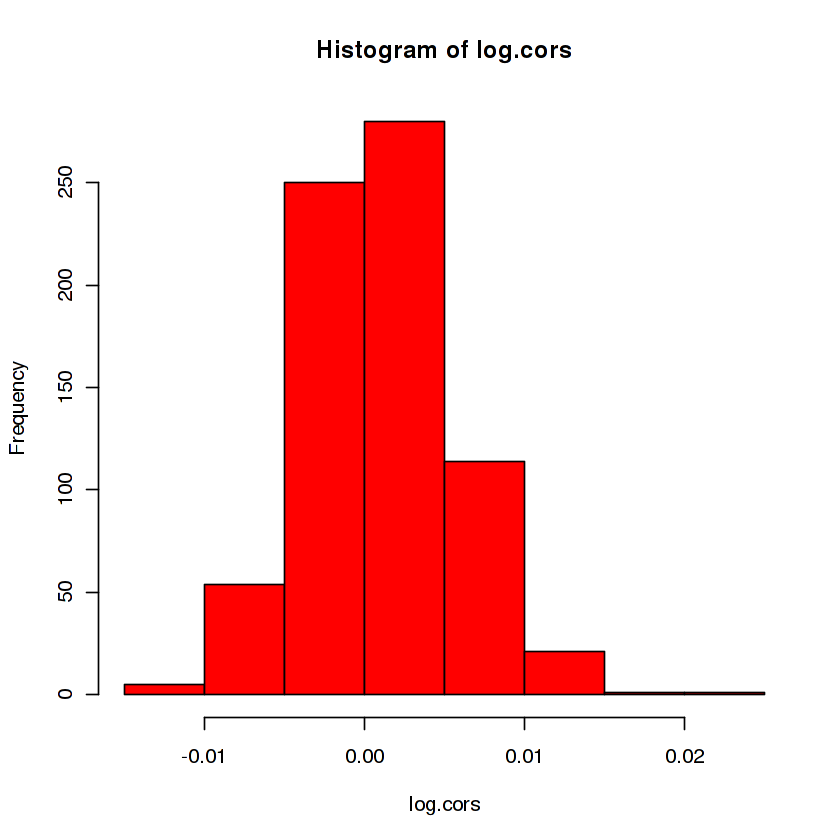

In [7]:
log.cors <- sapply(seq(ncol(x)), function(i)cor(log2(1 + y), log2(1 + x[, i])))
hist(log.cors, col= "red")

**Apparently log transforming the data reduces the association between features and response**

## Remove zero-expressed genes

In [8]:
zeros.idx <- which(y == 0)
print(length(zeros.idx))

[1] 29948


In [9]:
x_filtered <- x[-zeros.idx, ]
y_filtered <- y[-zeros.idx]

In [10]:
print(dim(x_filtered))
print(length(y_filtered))

[1] 22579   726
[1] 22579


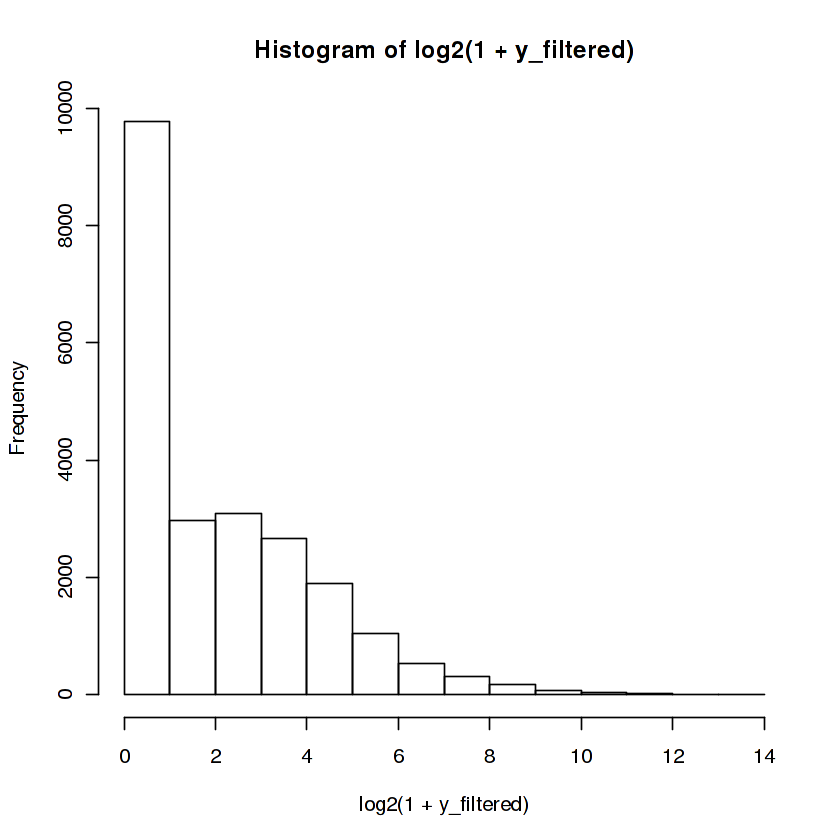

In [11]:
hist(log2(1 + y_filtered))

## Compute feature to response correlations (filtered data)

### Raw filtered data (original space)

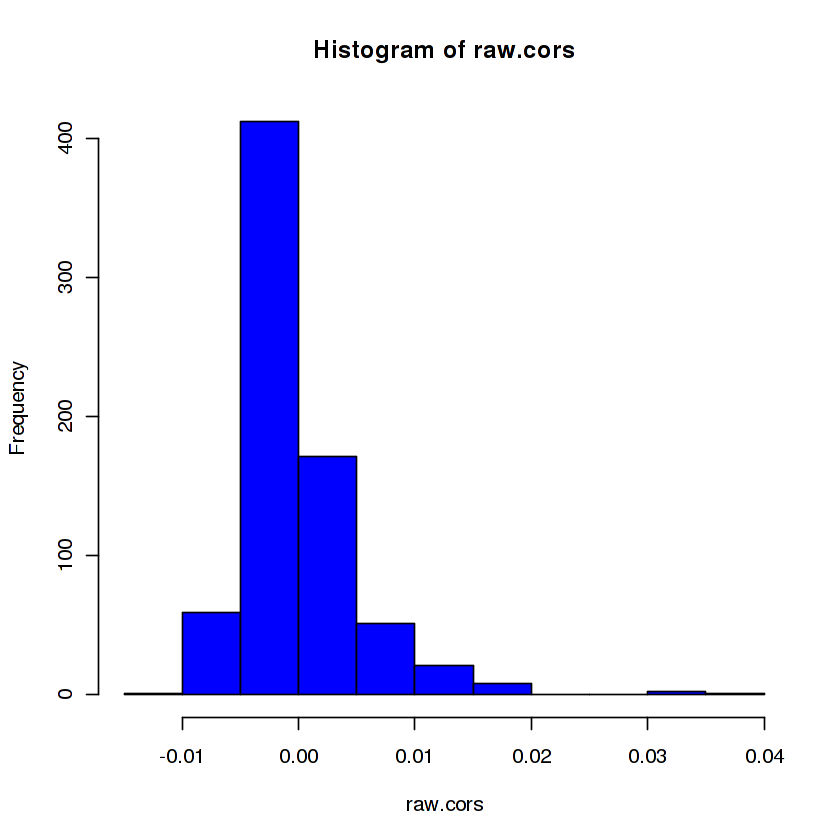

In [12]:
raw.cors <- sapply(seq(ncol(x_filtered)), function(i)cor(y_filtered, x_filtered[, i]))

hist(raw.cors, col= "blue")

### Log-transformed filtered data (log space)

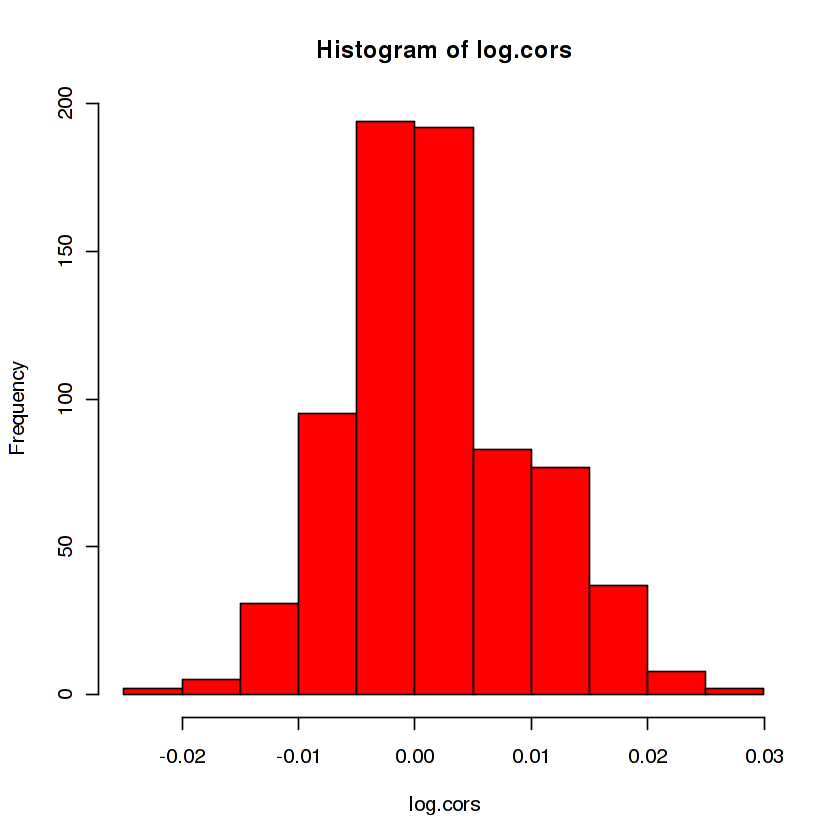

In [13]:
log.cors <- sapply(seq(ncol(x_filtered)), function(i)cor(log2(1 + y_filtered), log2(1 + x_filtered[, i])))

hist(log.cors, col= "red")

# Conclusion
* We examined the influence of the window size ([100bp](https://github.com/fba67/scMTL/blob/master/feat2resp_bulk_LiHe_100bpWinTF.ipynb) and [200bp](https://github.com/fba67/scMTL/blob/master/feat2resp_bulk_LiHe_200bpWinTF.ipynb)) used to annotate the TF binding affinities around the TSS on the feature values and how that affects the strength of linear association between features and response
* Also, measured the correlation between each TF and gene expression for both 1) raw and 2) log-transformed data. It seems like the raw data results in a better correlation, but overall the values are quite small
* We filtered the zero-expressed genes (doscarded ~30,000 genes with exact zero expression), hoping that this would improve the correlation and yet no luck (the improvement is extremely negligible)